In [41]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import os, sys
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
sys.path.append("/workspace/localizing-edm/")

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns
from torchinfo import summary
import json
import torch
import dnnlib
import pickle
import pandas as pd
import numpy as np

from scorer import VEScorer, plot_score_grid
from flows import ScoreFlow, build_model, log_density
from torch.nn.functional import interpolate

root = '/workspace/localizing-edm/workdir/runs'
model_file = f"{root}/finetune_cifar/00024-mvtec_hazelnut_128-uncond-ncsnpp-ve-gpus2-batch128-fp32/network-snapshot-010095.pkl"
device = torch.device('cuda')

with dnnlib.util.open_url(model_file) as f:
    model = pickle.load(f)
    net = model["ema"]
model.keys()

dict_keys(['ema', 'loss_fn', 'augment_pipe', 'dataset_kwargs'])

In [44]:
model_root = "/".join(model_file.split("/")[:-1])
model_root

'/workspace/localizing-edm/workdir/runs/finetune_cifar/00024-mvtec_hazelnut_128-uncond-ncsnpp-ve-gpus2-batch128-fp32'

In [45]:
with open(f"{model_root}/stats.jsonl", "r") as f:
    stats = pd.read_json(path_or_buf=f, lines=True)

# Extraact the nested object from the first line
nested_object = stats['Loss/loss']

# Convert the nested object to a DataFrame
df = pd.DataFrame.from_records(nested_object)

# Display the DataFrame
print(df)

           num      mean       std
0      6291456  0.029795  0.153952
1    497025024  0.030935  0.156265
2    497025024  0.033160  0.163131
3    497025024  0.033437  0.164635
4    497025024  0.031798  0.160568
..         ...       ...       ...
800  497025024  0.027369  0.137489
801  497025024  0.025982  0.132117
802  497025024  0.027463  0.137714
803  497025024  0.027549  0.137662
804  497025024  0.027568  0.139200

[805 rows x 3 columns]


<AxesSubplot: >

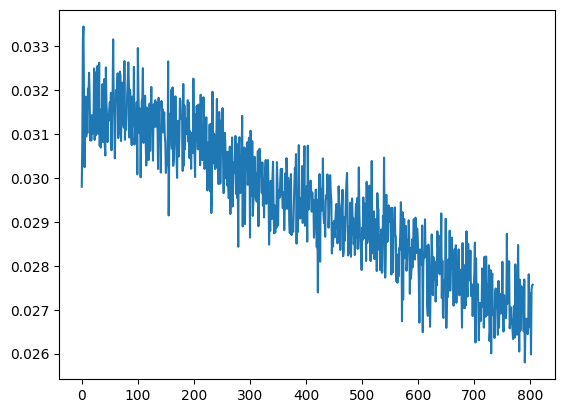

In [46]:
df['mean'].plot()

In [47]:
net.init_kwargs

{'model_type': 'SongUNet',
 'embedding_type': 'fourier',
 'encoder_type': 'residual',
 'decoder_type': 'standard',
 'channel_mult_noise': 2,
 'resample_filter': [1, 3, 3, 1],
 'model_channels': 128,
 'channel_mult': (1, 2, 2, 2),
 'augment_dim': 15,
 'dropout': 0.1,
 'use_fp16': False,
 'num_blocks': 4,
 'img_resolution': 32,
 'img_channels': 3,
 'label_dim': 0}

In [48]:
model["augment_pipe"].init_kwargs

{'p': 0.08,
 'xflip': 100000000.0,
 'yflip': 1,
 'scale': 1,
 'rotate_frac': 1,
 'aniso': 1,
 'translate_frac': 1,
 'brightness': 1,
 'contrast': 1,
 'lumaflip': 1,
 'hue': 1,
 'saturation': 1}

In [49]:
model["dataset_kwargs"]

{'class_name': 'training.dataset.MVTecDataset',
 'path': '/DATA/Users/amahmood/GDrive/MVTec_AD/hazelnut',
 'use_labels': False,
 'xflip': False,
 'cache': True,
 'resolution': 128,
 'max_size': 391}

In [50]:
res =  model["dataset_kwargs"]["resolution"]

In [55]:

# summary(flownet, input_data=torch.ones(1,3, res, res))

In [78]:
flow_path = "/workspace/localizing-edm/workdir/runs/cifar-base/smin=1e-1//"
config = pd.read_json(f"{flow_path}/config.json")
config

In [86]:
num_sigmas = config.config.loc['num_sigmas']
hres_blocks = config.config.loc['hres_blocks']
lres_blocks = config.config.loc['lres_blocks']
use_fp16 = config.config.loc['fp16']
min_sigma = config.config['sigma_min']

In [181]:
conv_inn = build_model((num_sigmas, res, res), num_hres_blocks=hres_blocks, num_lres_blocks=lres_blocks)
flownet = ScoreFlow(conv_inn, net, num_sigmas=num_sigmas, use_fp16=use_fp16, sigma_min=min_sigma,
                    post_downsample=True).to(device)
state_dict = torch.load(f"{flow_path}/checkpoint.pth")
flownet.load_state_dict(state_dict["model_state_dict"], strict=True)
print("Loaded")

Loaded


In [182]:
summary(flownet.flow, input_data=torch.ones(1,num_sigmas, res, res))

Layer (type:depth-idx)                   Output Shape              Param #
GraphINN                                 [1, 80, 64, 64]           --
├─ModuleList: 1-1                        --                        --
│    └─GLOWCouplingBlock: 2-1            [1, 20, 128, 128]         --
│    │    └─Sequential: 3-1              [1, 20, 128, 128]         69,396
│    │    └─Sequential: 3-2              [1, 20, 128, 128]         69,396
│    └─PermuteRandom: 2-2                [1, 20, 128, 128]         (40)
│    └─GLOWCouplingBlock: 2-3            [1, 20, 128, 128]         --
│    │    └─Sequential: 3-3              [1, 20, 128, 128]         69,396
│    │    └─Sequential: 3-4              [1, 20, 128, 128]         69,396
│    └─PermuteRandom: 2-4                [1, 20, 128, 128]         (40)
│    └─IRevNetDownsampling: 2-5          [1, 80, 64, 64]           (320)
│    └─GLOWCouplingBlock: 2-6            [1, 80, 64, 64]           --
│    │    └─Sequential: 3-5              [1, 80, 64, 64]      

<AxesSubplot: >

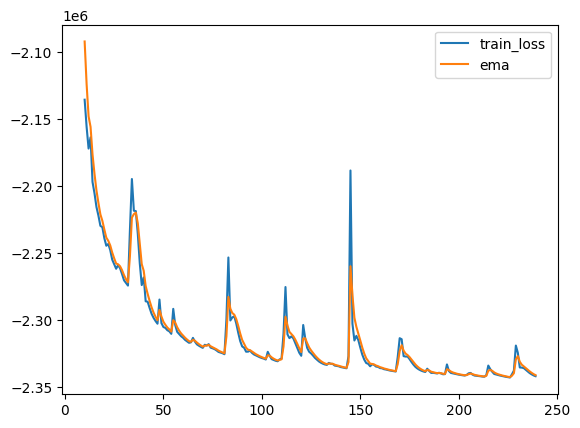

In [183]:
df = pd.read_csv(f"{flow_path}/losses.csv")
df[10:].plot()

In [184]:
from training.dataset import MVTecDataset

mvtec_ds = MVTecDataset(path="/DATA/Users/amahmood/GDrive/MVTec_AD/hazelnut",
                        train=False, resolution=256)
inlier_batch, _ = mvtec_ds.load_test(only_normal=True)
ood_batch, mask = mvtec_ds.load_test(skip_normal=True)
inlier_batch = torch.stack(inlier_batch).to(device) / 127.5 - 1
ood_batch = torch.stack(ood_batch) / 127.5 - 1
mask = torch.stack(mask)
inlier_batch.shape, ood_batch.shape, ood_batch.dtype 

(torch.Size([40, 3, 256, 256]), torch.Size([70, 3, 256, 256]), torch.float32)

In [185]:
%%time
scores = flownet.scorenet(ood_batch[:4].cuda()).cpu()
scores.shape

CPU times: user 2.03 s, sys: 6.03 s, total: 8.06 s
Wall time: 8.06 s


torch.Size([4, 20, 128, 128])

In [186]:
flownet.scorenet.sigma_steps

tensor([80.0000, 56.2724, 39.5823, 27.8424, 19.5845, 13.7759,  9.6900,  6.8160,
         4.7944,  3.3724,  2.3722,  1.6686,  1.1737,  0.8256,  0.5807,  0.4085,
         0.2873,  0.2021,  0.1422,  0.1000], device='cuda:0',
       dtype=torch.float64)

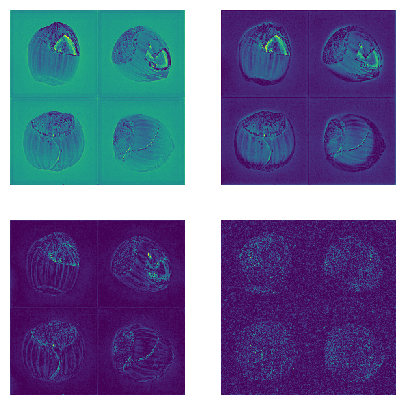

In [187]:
plot_score_grid(scores, num_samples=4, plot_sigma_idxs = [1, 7, 11, 19])

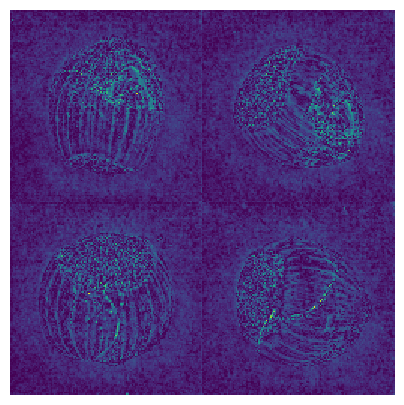

In [188]:
plot_score_grid(scores.sum(dim=1, keepdims=True), num_samples=4, plot_sigma_idxs = [0])

In [189]:
%%time
ood_logpx = []
for x_ood_batch in ood_batch.chunk(10):
    ood_logpx.append(log_density(flownet, x_ood_batch.cuda()).cpu())
ood_logpx = torch.cat(ood_logpx)

CPU times: user 31.5 s, sys: 1min 46s, total: 2min 17s
Wall time: 2min 18s


In [190]:
ood_logpx.shape

torch.Size([70, 1, 64, 64])

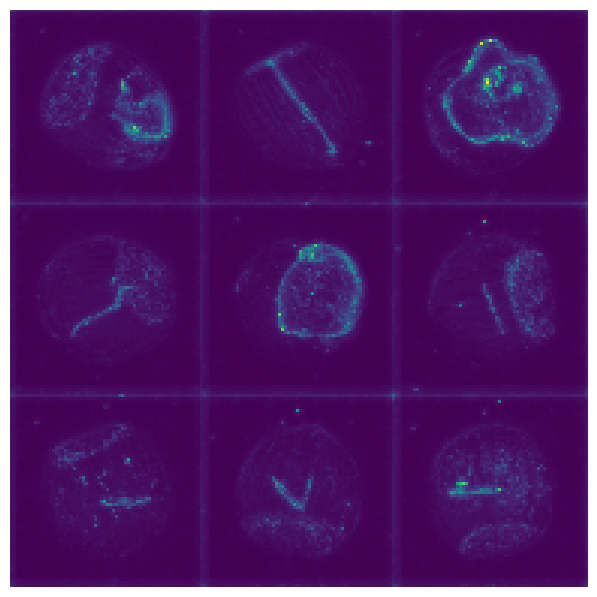

In [191]:
plot_score_grid(ood_logpx[1::4], plot_sigma_idxs=[0])

In [192]:
%%time
inlier_logpx = []
for x_batch in inlier_batch.chunk(10):
    inlier_logpx.append(log_density(flownet, x_batch.cuda()).cpu())
inlier_logpx = torch.cat(inlier_logpx)

CPU times: user 20.2 s, sys: 1min, total: 1min 20s
Wall time: 1min 20s


In [193]:
import torch
import matplotlib.pyplot as plt
import torchvision.utils as vutils
import matplotlib.colors as colors
import cv2 as cv

def plot_batch_with_heatmaps(images_batch, anomaly_maps, grid_size=(5, 5), blur_radius=5,
                             alpha=0.5, symmetric_norm=True, linthresh_q=0.9):
    # Ensure anomaly_maps have an additional dimension for color channel
#     anomaly_maps = anomaly_maps.unsqueeze(-1)
    
    # Not considering log probabilities higher than threshold
    anomaly_maps = anomaly_maps.clip(max=-2529890.5)
    anomaly_maps = - anomaly_maps.squeeze(1)
    
    # Putting batch as "channel" dimension
    # so kernel is run over all batches (independently)
    anomaly_maps = anomaly_maps.transpose(1,2,0)
    anomaly_maps = cv.blur(anomaly_maps, ksize=(blur_radius,blur_radius))
    anomaly_maps = anomaly_maps.transpose(2,0,1)
    
    amin = anomaly_maps.min(axis=(1,2), keepdims=True)
    amax = anomaly_maps.max(axis=(1,2), keepdims=True) 
    anomaly_maps = (anomaly_maps - amin / (amax-amin))
    
    if symmetric_norm:
        norm=colors.SymLogNorm(linthresh=np.quantile(anomaly_maps,linthresh_q),
                               vmin=np.quantile(anomaly_maps,0.01),
                               vmax=np.quantile(anomaly_maps,0.99))
    else:
        norm=colors.LogNorm(vmin=np.quantile(anomaly_maps,0.01),
                            vmax=np.quantile(anomaly_maps,0.99))
    shape = anomaly_maps.shape
    anomaly_maps  = norm(anomaly_maps.ravel()).reshape(*shape)
    
    # Expand anomaly_maps to 3 color channels and apply colormap
    anomaly_maps_rgb = plt.get_cmap('jet')(anomaly_maps)[:,:,:,:3]
#     anomaly_maps = cv.blur(anomaly_maps, (blur_radius, blur_radius))
#     print(anomaly_maps_rgb.shape)
    anomaly_maps_rgb = torch.from_numpy(anomaly_maps_rgb).float()
    anomaly_maps_rgb = anomaly_maps_rgb.permute(0,3,1,2)
    
    # Merge images with anomaly maps with given alpha
    overlaid_images = alpha * images_batch + (1-alpha) * anomaly_maps_rgb
#     print(overlaid_images.shape)
    # Convert batch of tensors to grid
    grid = vutils.make_grid(overlaid_images, nrow=grid_size[1], padding=2, normalize=True)
    
    # Plot grid
    plt.figure(figsize=(10,10))
    plt.axis("off")
    plt.imshow(np.transpose(grid.numpy(),(1,2,0)))
    
    return anomaly_maps_rgb

In [196]:
# assuming images_batch and anomaly_maps are your data
batch_size = 9
torch.manual_seed(42)
rand_idxs = torch.randperm(ood_batch.shape[0])[:batch_size]
images_batch = ood_batch[rand_idxs].cpu()
heatmap = interpolate(ood_logpx[rand_idxs], scale_factor=4, mode="bilinear", align_corners=False).cpu().contiguous().numpy()

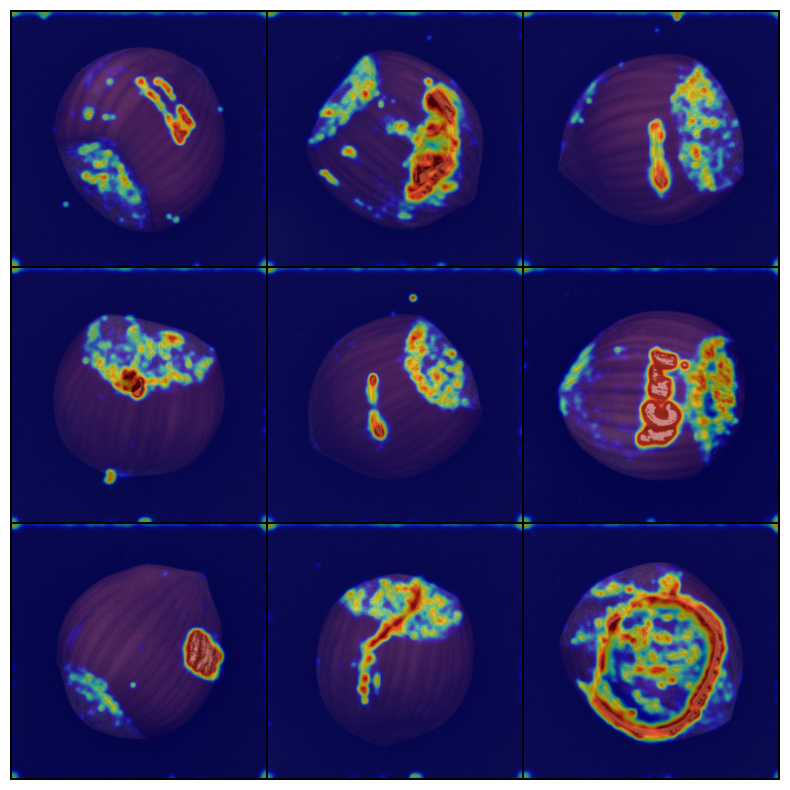

In [202]:
# define grid size and alpha for heatmap opacity
grid_size = (3, 3)
alpha = 0.35

# Call the function with the RGB image batch and the anomaly maps batch
ano = plot_batch_with_heatmaps(images_batch, heatmap, grid_size=grid_size, alpha=alpha, linthresh_q=0.95)

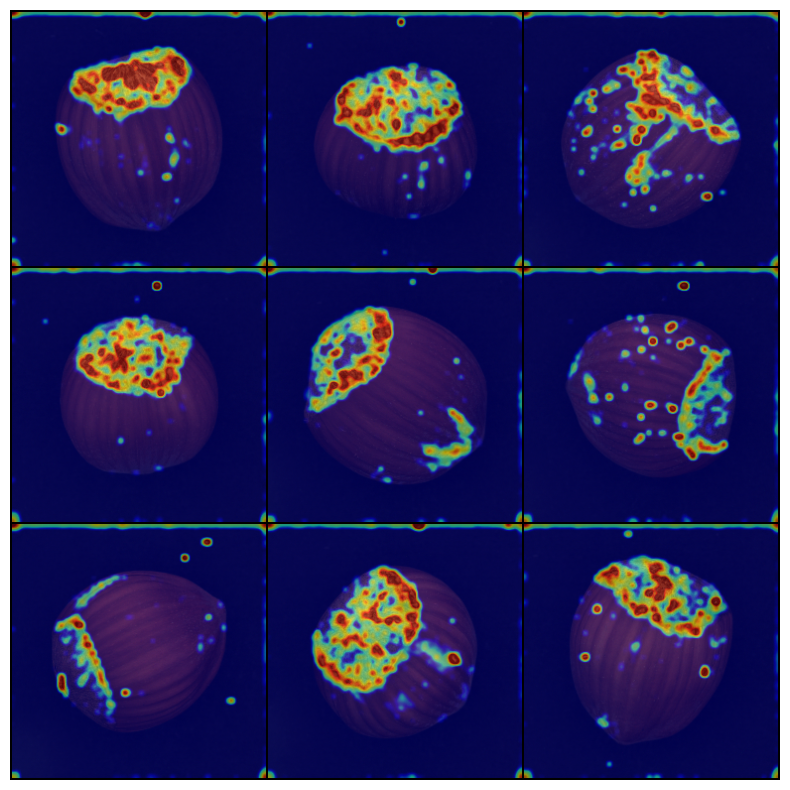

In [199]:
# assuming images_batch and anomaly_maps are your data
batch_size = 9
torch.manual_seed(42)
rand_idxs = torch.randperm(inlier_batch.shape[0])[:batch_size]
inlier_images_batch = inlier_batch[rand_idxs].cpu()
inlier_heatmap = interpolate(inlier_logpx[rand_idxs], scale_factor=4, mode="bilinear", align_corners=False).cpu().numpy()

# define grid size and alpha for heatmap opacity
grid_size = (3, 3)
alpha = 0.35

# Call the function with the RGB image batch and the anomaly maps batch
ano = plot_batch_with_heatmaps(inlier_images_batch, inlier_heatmap, grid_size=grid_size, alpha=alpha, linthresh_q=0.9)

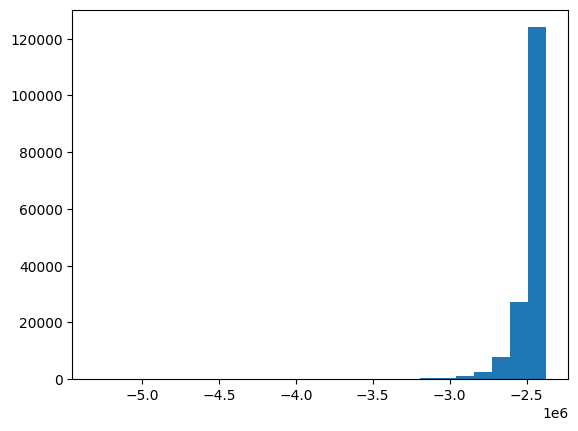

In [200]:
dist = inlier_logpx.ravel()
plt.hist(dist, bins=25);

In [201]:
inlier_logpx.mean()

tensor(-2463712.7500)